Contents

1.Data Information

2.Exploratory Data Analysis

    - Include Libraries
    - Import Data
    - Explore Data
    - Missing Values

3.Data Visualization

    - Distribution plot
    - Pairplot
    - Correlation map

4.Preparing Data for the Model

    - Splitting data
    - Standardization

5.Machine Learning Model

    - XGboost regressor



**Data Set Information:**

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.



Attribute Information:

Features consist of hourly average ambient variables

* Temperature (T) in the range 1.81°C and 37.11°C,
* Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
* Relative Humidity (RH) in the range 25.56% to 100.16%
* Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
* Net hourly electrical energy output (EP) 420.26-495.76 MW.

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy import stats


In [31]:
data = pd.read_csv("Folds5x2_pp.csv")

In [32]:
data.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [34]:
data.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [35]:
data.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [36]:
column_mapping = {
    'AT': 'Temperature',
    'AP': 'AmbientPressure',
    'RH': 'RelativeHumidity',
    'V': 'ExhaustVacuum',
    'PE': 'NetEnergyOutput'
}

# Rename the columns using the rename() function
data.rename(columns=column_mapping, inplace=True)

# Print the updated column names
print(data.columns)

Index(['Temperature', 'ExhaustVacuum', 'AmbientPressure', 'RelativeHumidity',
       'NetEnergyOutput'],
      dtype='object')


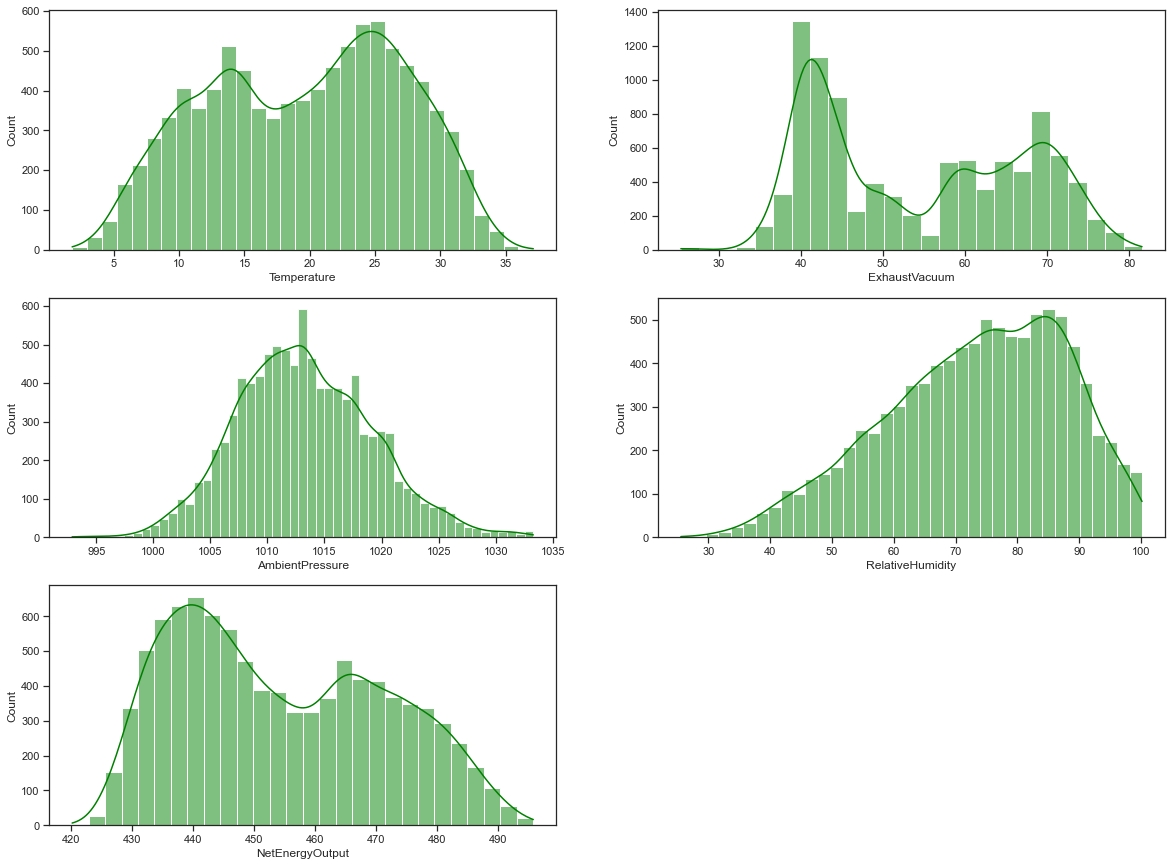

In [37]:
#Distribution of the dataset
plt.figure(figsize=(20,15))
j = 1
for i in data.columns:
    plt.subplot(3,2,j)
    sns.histplot(data[i], kde= True, color = "green")
    j+=1


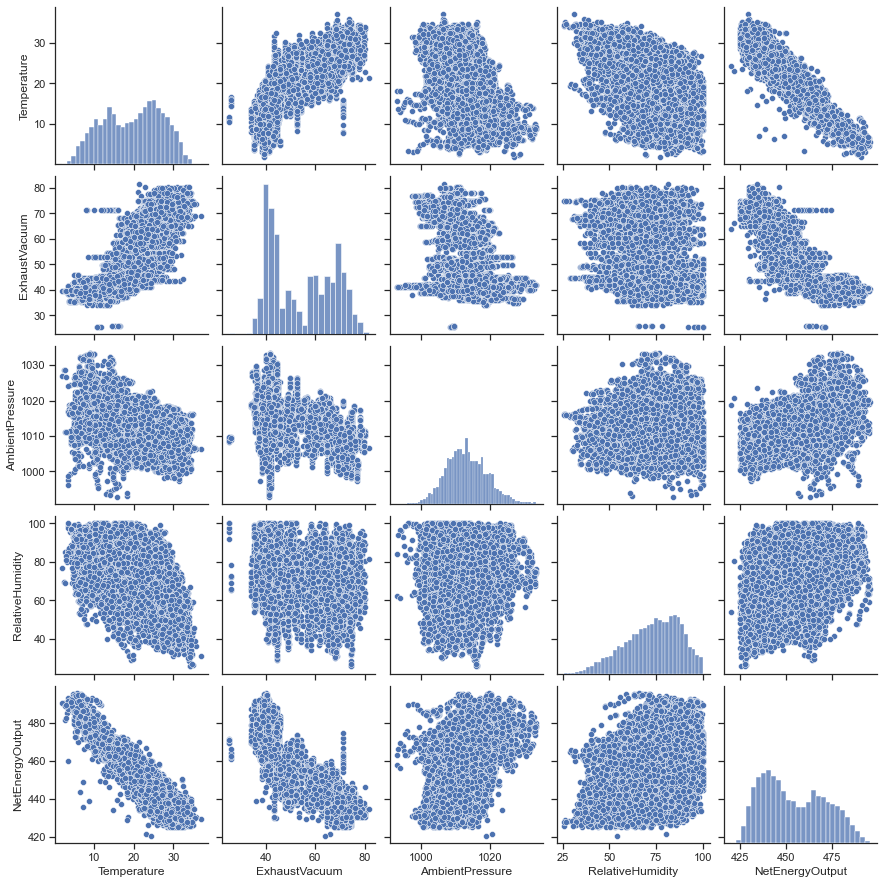

In [38]:
sns.pairplot(data= data, diag_kind="hist")

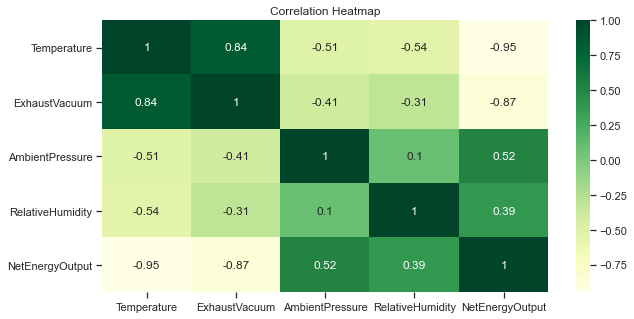

<function matplotlib.pyplot.subplots(nrows=1, ncols=1, *, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)>

In [39]:
# Create a correlation heatmap

correlation_matrix = data.corr()
sns.set_theme(style="ticks")

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn')
plt.title('Correlation Heatmap')
plt.show()

plt.subplots

 - NetEngergyOutput has a high negative correlation with "Temperature" and "ExhaustVacuum".



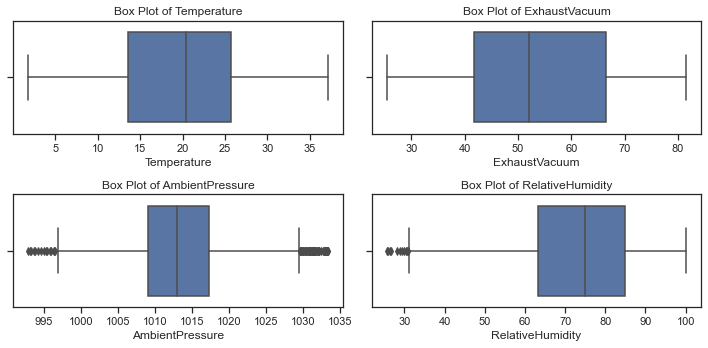

In [40]:
plt.figure(figsize=(10, 5))
features = data.columns[:-1]  # Exclude the target variable
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=data[feature])
    plt.title('Box Plot of {}'.format(feature))
    plt.tight_layout()

plt.show()

 - Since there are outliers present in "Ambient Pressure" and "Relative Humidity", we can remove these using z-score threshold.


In [41]:
z_threshold = 3

z_scores = np.abs(stats.zscore(data))
data_no_outliers = data[(z_scores < z_threshold).all(axis=1)]
num_outliers_removed = len(data) - len(data_no_outliers)
print("Number of outliers removed:", num_outliers_removed)

Number of outliers removed: 58


In [42]:
#Splitting the dataset into target and dependent variables.
X = data.drop('NetEnergyOutput', axis=1)  # Dependent Variables
y = data['NetEnergyOutput']  # Target variable

In [43]:
# Standardize the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [44]:
#Splitting the datset into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
#creating a XGboost model

xgb_reg = xgb.XGBRegressor()

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

# Print the mean squared error of the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 3.043881708773918


In [46]:
xg_score = xgb_reg.score(X_test, y_test)
print("Score:",xg_score)


Score: 0.967620457695106


In [47]:
# Creating a dataframe to display the actual and predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Print the dataframe
print(df.head())

      Actual   Predicted
2513  433.27  434.161102
9411  438.16  438.696869
8745  458.42  460.503998
9085  480.82  477.752472
4950  441.41  442.251556
